In [1]:
import nltk
import warnings

warnings.filterwarnings('ignore')
nltk.download("all", quiet=True)


True

In [2]:
import random, os
import numpy as np
import torch

def seed_everything(seed: int):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    
seed_everything(42)


In [3]:
import datasets
import pandas as pd
from ast import literal_eval
datasets.set_caching_enabled(False)

data_dir = '../input/vispamdataset-v2/preprocessed/'

def load_data(data_dir):
    train_df = pd.read_csv(data_dir + 'train.csv', converters={'categories': literal_eval})
    dev_df = pd.read_csv(data_dir + 'dev.csv', converters={'categories': literal_eval})
    test_df = pd.read_csv(data_dir + 'test.csv', converters={'categories': literal_eval})
    
    train_dataset = datasets.Dataset.from_dict(train_df)
    dev_dataset = datasets.Dataset.from_dict(dev_df)
    test_dataset = datasets.Dataset.from_dict(test_df)
    dataset_dict = datasets.DatasetDict({'train': train_dataset, 'dev': dev_dataset, 'test': test_dataset})
    
    return dataset_dict

vispam_datasets = load_data(data_dir)


In [4]:
import numpy as np
from nltk.tokenize import word_tokenize

def tokenizing(texts):
    max_len = 0
    tokenized_texts = []
    word2idx = {}
    
    word2idx['<pad>'] = 0
    word2idx['<unk>'] = 1
    
    idx = 2
    for sent in texts:
        tokenized_sent = word_tokenize(sent)
        tokenized_texts.append(tokenized_sent)
        
        for token in tokenized_sent:
            if token not in word2idx:
                word2idx[token] = idx
                idx += 1
                
        max_len = max(max_len, len(tokenized_sent))
        
    return tokenized_texts, word2idx, max_len


def encoding(tokenized_texts, word2idx, max_len=100):
    input_ids = []
    for tokenized_sent in tokenized_texts:
        if len(tokenized_sent) > max_len:
            tokenized_sent = tokenized_sent[:max_len]
            
        tokenized_sent += ['<pad>'] * (max_len - len(tokenized_sent))
        
        input_id = [word2idx.get(token, word2idx['<unk>']) for token in tokenized_sent]
        input_ids.append(input_id)
    
    return np.array(input_ids)


train_tokenized, word2idx, max_len = tokenizing(vispam_datasets['train']['clean_comment'])
print('Number of words:', len(word2idx))
print('Max length of sentence:', max_len)


Number of words: 15359
Max length of sentence: 215


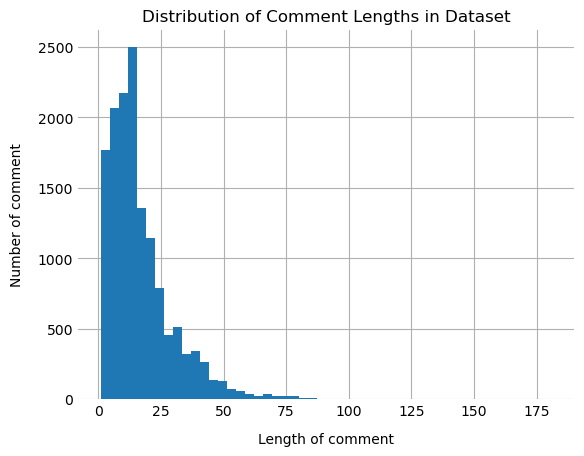

In [5]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.hist([len(s.split()) for s in vispam_datasets['train']['clean_comment']], bins=50)
ax.set_title('Distribution of Comment Lengths in Dataset', fontsize=12)
ax.set_xlabel("Length of comment", fontsize=10, labelpad=10)
ax.set_ylabel('Number of comment', fontsize=10, labelpad=10)
for pos in ['right', 'top', 'left', 'bottom']:
    ax.spines[pos].set_visible(False)
ax.tick_params(axis='both', which='both', length=0)
ax.grid()
ax.set_axisbelow(True)
plt.show()


In [6]:
def encode_mapping(examples):
    tokenized_texts = [word_tokenize(sent) for sent in examples['clean_comment']]
    input_ids = encoding(tokenized_texts, word2idx, max_len=100)
    
    return {'input_ids': input_ids}


encoded_datasets = vispam_datasets.map(encode_mapping, batched=True)
encoded_datasets = encoded_datasets.remove_columns(vispam_datasets['train'].column_names[:-2])
encoded_datasets.set_format("torch")


  0%|          | 0/15 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/4 [00:00<?, ?ba/s]

In [7]:
import torch
import numpy as np
from tqdm import tqdm_notebook

def load_pretrained_vectors(word2idx, file_name):
    fin = open(file_name, 'r', encoding='utf-8', newline='\n', errors='ignore')
    n, d = map(int, fin.readline().split())
    
    embeddings = np.random.uniform(-0.25, 0.25, (len(word2idx), d))
    embeddings[word2idx['<pad>']] = np.zeros((d,))
    
    count = 0
    for line in tqdm_notebook(fin):
        tokens = line.rstrip().split(' ')
        word = tokens[0]
        if word in word2idx:
            count += 1
            embeddings[word2idx[word]] = np.array(tokens[1:], dtype=np.float32)
            
    print(f"There are {count} / {len(word2idx)} pretrained vectors found.")
    
    return embeddings


file_name = "/kaggle/input/fasttext-pretrained-embeddings/cc.vi.300.vec"
embeddings = load_pretrained_vectors(word2idx, file_name)
embeddings = torch.tensor(embeddings)


0it [00:00, ?it/s]

There are 8584 / 15359 pretrained vectors found.


In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class TextCNN(nn.Module):
    def __init__(self, task, kernel_sizes=[2, 3, 5], num_filters=32, drop=0.5, spatial_dropout=False, mode='static'):
        super(TextCNN, self).__init__()
        
        self.task = task
        self.num_classes = 2 if task == 1 else 4
        self.vocab_size, self.embedding_dim = embeddings.shape
        self.kernel_sizes = kernel_sizes
        self.num_filters = num_filters
        self.drop = drop
        self.spatial_dropout = spatial_dropout
        self.mode = mode
        
        self.embedding = nn.Embedding(self.vocab_size, self.embedding_dim, padding_idx=0)
        self.load_embeddings()
        
        if spatial_dropout:
            self.spatial_dropout1d = nn.Dropout2d(drop)
            
        self.conv = nn.ModuleList([nn.Conv1d(in_channels=self.embedding_dim, out_channels=num_filters, kernel_size=k, stride=1) for k in kernel_sizes])
        self.dropout = nn.Dropout(drop)
        self.fc = nn.Linear(len(kernel_sizes) * num_filters, self.num_classes)

    def forward(self, input_ids):
        batch_size, sequence_length = input_ids.shape
        h_embedding = self.embedding(input_ids).float()
        
        if self.spatial_dropout:
            h_embedding = h_embedding.permute(0, 2, 1)
            h_embedding = self.spatial_dropout1d(h_embedding)
            h_embedding = h_embedding.permute(0, 2, 1)
        
        x = h_embedding.permute(0, 2, 1)
        x = [F.relu(conv(x)) for conv in self.conv]
        x = [F.max_pool1d(c, kernel_size=c.shape[2]).squeeze(dim=2) for c in x]
        x = torch.cat(x, dim=1)
        x = self.dropout(x)
        x = self.fc(x)
        
        return x

    def load_embeddings(self):
        if 'static' in self.mode:
            self.embedding.weight.data.copy_(embeddings)
            if 'non' not in self.mode:
                self.embedding.weight.data.requires_grad = False
                print('Loaded pretrained embeddings, weights are not trainable.')
            else:
                self.embedding.weight.data.requires_grad = True
                print('Loaded pretrained embeddings, weights are trainable.')
        elif self.mode == 'rand':
            print('Randomly initialized embeddings are used.')
        else:
            raise ValueError('Unexpected value of mode. Please choose from static, non-static, rand.')
            

class BiLSTM(nn.Module):
    
    def __init__(self, task, hidden_size=64, drop=0.5, spatial_dropout=True, mode='static'):
        super(BiLSTM, self).__init__()
        
        self.task = task
        self.num_classes = 2 if task == 1 else 4
        self.vocab_size, self.embedding_dim = embeddings.shape
        self.hidden_size = hidden_size
        self.drop = drop
        self.spatial_dropout = spatial_dropout
        self.mode = mode
        
        if spatial_dropout:
            self.spatial_dropout1d = nn.Dropout2d(drop)
        
        self.embedding = nn.Embedding(self.vocab_size, self.embedding_dim, padding_idx=0)
        self.load_embeddings()
        self.lstm = nn.LSTM(self.embedding_dim, hidden_size, bidirectional=True, batch_first=True)
        self.linear = nn.Linear(hidden_size*4 , 64)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(drop)
        self.fc = nn.Linear(64, self.num_classes)
        
    def forward(self, input_ids):
        batch_size, sequence_length = input_ids.shape
        h_embedding = self.embedding(input_ids).float()
        
        if self.spatial_dropout:
            h_embedding = h_embedding.permute(0, 2, 1)
            h_embedding = self.spatial_dropout1d(h_embedding)
            h_embedding = h_embedding.permute(0, 2, 1)
        
        h_lstm, _ = self.lstm(h_embedding)
        avg_pool = torch.mean(h_lstm, 1)
        max_pool, _ = torch.max(h_lstm, 1)
        conc = torch.cat((avg_pool, max_pool), 1)
        conc = self.relu(self.linear(conc))
        conc = self.dropout(conc)
        out = self.fc(conc)
        
        return out
    
    def load_embeddings(self):
        if 'static' in self.mode:
            self.embedding.weight.data.copy_(embeddings)
            if 'non' not in self.mode:
                self.embedding.weight.data.requires_grad = False
                print('Loaded pretrained embeddings, weights are not trainable.')
            else:
                self.embedding.weight.data.requires_grad = True
                print('Loaded pretrained embeddings, weights are trainable.')
        elif self.mode == 'rand':
            print('Randomly initialized embeddings are used.')
        else:
            raise ValueError('Unexpected value of mode. Please choose from static, non-static, rand.')
            

class BiGRU(nn.Module):
    
    def __init__(self, task, hidden_size=64, drop=0.5, spatial_dropout=True, mode='static'):
        super(BiGRU, self).__init__()
        
        self.task = task
        self.num_classes = 2 if task == 1 else 4
        self.vocab_size, self.embedding_dim = embeddings.shape
        self.hidden_size = hidden_size
        self.drop = drop
        self.spatial_dropout = spatial_dropout
        self.mode = mode
        
        self.embedding = nn.Embedding(self.vocab_size, self.embedding_dim, padding_idx=0)
        
        if spatial_dropout:
            self.spatial_dropout1d = nn.Dropout2d(drop)
        
        self.load_embeddings()
        self.gru = nn.GRU(self.embedding_dim, hidden_size, bidirectional=True, batch_first=True)
        self.linear = nn.Linear(hidden_size*4, 64)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(drop)
        self.fc = nn.Linear(64, self.num_classes)
        
    def forward(self, input_ids):
        batch_size, sequence_length = input_ids.shape
        h_embedding = self.embedding(input_ids).float()
        
        if self.spatial_dropout:
            h_embedding = h_embedding.permute(0, 2, 1)
            h_embedding = self.spatial_dropout1d(h_embedding)
            h_embedding = h_embedding.permute(0, 2, 1)
            
        h_gru, _ = self.gru(h_embedding)
        avg_pool = torch.mean(h_gru, 1)
        max_pool, _ = torch.max(h_gru, 1)
        conc = torch.cat((avg_pool, max_pool), 1)
        conc = self.relu(self.linear(conc))
        conc = self.dropout(conc)
        out = self.fc(conc)
        
        return out
    
    def load_embeddings(self):
        if 'static' in self.mode:
            self.embedding.weight.data.copy_(embeddings)
            if 'non' not in self.mode:
                self.embedding.weight.data.requires_grad = False
                print('Loaded pretrained embeddings, weights are not trainable.')
            else:
                self.embedding.weight.data.requires_grad = True
                print('Loaded pretrained embeddings, weights are trainable.')
        elif self.mode == 'rand':
            print('Randomly initialized embeddings are used.')
        else:
            raise ValueError('Unexpected value of mode. Please choose from static, non-static, rand.')
            

In [9]:
import torch
import numpy as np

class EarlyStopping:
    
    def __init__(self, patience=5, verbose=True, delta=0, path='checkpoint.pth'):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        
    def __call__(self, val_loss, model):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0
            
    def save_checkpoint(self, val_loss, model):
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}). Saving model ...')
            
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss
        

In [10]:
import os
import gc
import json
import numpy as np
from scipy import interpolate
from pathlib import Path
import torch
from torch import nn
from tqdm.notebook import tqdm
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import plotly.graph_objects as go
from plotly.subplots import make_subplots
from plotly.offline import init_notebook_mode, iplot, plot

def train_step(model, criterion, optimizer, train_dataloader, task):
    model.train()
    losses = []
    correct = 0
    
    trues = []
    predicts = []
    
    label_column = 'label' if task == 1 else 'spam_label'
    
    for data in tqdm(train_dataloader):
        input_ids = data['input_ids'].to(device)
        labels = data[label_column].to(device)
        
        optimizer.zero_grad()
        outputs = model(input_ids)
        
        loss = criterion(outputs, labels)
        pred = torch.max(outputs, dim=1)[1]
        
        correct += torch.sum(pred == labels)
        losses.append(loss.item())
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        
        trues.extend(labels.cpu().detach().numpy())
        predicts.extend(pred.cpu().detach().numpy())
        
    accuracy = correct.double().cpu().data.numpy()/len(train_dataloader.dataset)
    loss = np.mean(losses)

    return accuracy, f1_score(trues, predicts, average='macro'), loss


def validation_step(model, criterion, dataloader, task):
    model.eval()
    losses = []
    correct = 0
    
    trues = []
    predicts = []
    
    label_column = 'label' if task == 1 else 'spam_label'
    
    with torch.no_grad():
        for data in dataloader:
            input_ids = data['input_ids'].to(device)
            labels = data[label_column].to(device)

            outputs = model(input_ids)
            pred = torch.max(outputs, dim=1)[1]
            
            loss = criterion(outputs, labels)
            correct += torch.sum(pred == labels)
            losses.append(loss.item())
            
            trues.extend(labels.cpu().detach().numpy())
            predicts.extend(pred.cpu().detach().numpy())

    accuracy = correct.double().cpu().data.numpy()/len(dataloader.dataset)
    loss = np.mean(losses)

    return accuracy, f1_score(trues, predicts, average='macro'), loss


def train(model, criterion, optimizer, train_dataloader, val_dataloader, epochs, model_name, early_stopping, task):
    torch.cuda.empty_cache()
    gc.collect()
    
    Path(model_name).mkdir(parents=True, exist_ok=True)
    
    if early_stopping:
        path_checkpoint = os.path.join(model_name, f"{model_name}_checkpoint_({task}).pth")
        early_stopping.path = path_checkpoint
    
    best_f1 = 0
    best_model_path = os.path.join(model_name, f"{model_name}_best_model_({task}).pth")
    last_model_path = os.path.join(model_name, f"{model_name}_last_model_({task}).pth")
    history = {'train_acc': [], 'train_loss': [], 'val_acc': [], 'val_loss': []}

    for epoch in range(epochs):
        print("Epoch {}/{}".format(epoch+1, epochs))
        print("-"*70)
        
        train_accuracy, train_f1, train_loss = train_step(model, criterion, optimizer, train_dataloader, task)
        val_accuracy, val_f1, val_loss = validation_step(model, criterion, val_dataloader, task)
        
        history['train_acc'].append(train_accuracy)
        history['train_loss'].append(train_loss)
        history['val_acc'].append(val_accuracy)
        history['val_loss'].append(val_loss)
        
        print("Train Accuracy: {:.4f} - Valid F1-score: {:.4f} - Train Loss: {:.4f}".format(train_accuracy, train_f1, train_loss))
        print("Valid Accuracy: {:.4f} - Valid F1-score: {:.4f} - Valid Loss: {:.4f}".format(val_accuracy, val_f1, val_loss))
        
        if val_f1 > best_f1:
            torch.save(model.state_dict(), best_model_path)
            best_f1 = val_f1
        
        if epoch + 1 == epochs:
            torch.save(model.state_dict(), last_model_path)
            break
            
        if early_stopping:
            early_stopping(val_loss, model)
            if early_stopping.early_stop:
                torch.save(model.state_dict(), last_model_path)
                print("Early stopping.")
                break
    
    history_path = os.path.join(model_name, f"{model_name}_history_({task}).json")
    with open(history_path, 'w') as f:
        json.dump(history, f)
        
    # with open(history_path) as f:
    #     history = json.load(f)
    
    return history
    

def test(model, dataloader, task):
    model.eval()
    
    predicts = []
    predict_probs = []
    true_labels = []
    
    label_column = 'label' if task == 1 else 'spam_label'
    
    for data in tqdm(dataloader):
        input_ids = data['input_ids'].to(device)
        labels = data[label_column].to(device)
        
        with torch.no_grad():
            outputs = model(input_ids)
         
        pred = torch.max(outputs, dim=1)[1]
        predicts.extend(pred.cpu().data.numpy())
        predict_probs.extend(outputs.cpu().data.numpy())
        true_labels.extend(labels.cpu().data.numpy())
        
    return true_labels, predicts


def evaluate(true_labels, predicts):
    test_accuracy = accuracy_score(true_labels, predicts)
    test_precision = precision_score(true_labels, predicts, average='macro')
    test_recall = recall_score(true_labels, predicts, average='macro')
    test_f1 = f1_score(true_labels, predicts, average='macro')
    test_cm = confusion_matrix(true_labels, predicts)

    print("Accuracy: {:.4f}".format(test_accuracy))
    print("Precision: {:.4f}".format(test_precision))
    print("Recall: {:.4f}".format(test_recall))
    print("F1-score: {:.4f}".format(test_f1))
    print("Confusion matrix:\n", test_cm)
    print(classification_report(true_labels, predicts, digits=4))
    
    return test_cm


def save_visualization_history(history, model_name, task):
    colors = plt.get_cmap('tab10').colors
    epochs = np.arange(1, len(history['train_loss']) + 1)
    xnew = np.linspace(epochs[0], epochs[-1], 300)
    
    train_loss_smooth = interpolate.interp1d(epochs, history['train_loss'], kind='linear')(xnew)
    val_loss_smooth = interpolate.interp1d(epochs, history['val_loss'], kind='linear')(xnew)

    fig, ax = plt.subplots()
    ax.plot(xnew, train_loss_smooth, color=colors[0], linewidth=3, label='Training Loss')
    ax.plot(xnew, val_loss_smooth, color=colors[1], linewidth=3, label='Validation Loss')
    ax.set_title('Training and Validation Loss', fontsize=12)
    ax.set_xlabel('Epoch', fontsize=10, labelpad=10)
    ax.set_ylabel('Loss', fontsize=10, labelpad=10)
    ax.tick_params(axis='both', which='both', length=0)
    ax.grid(axis='y')
    for pos in ['right', 'top', 'left', 'bottom']:
        ax.spines[pos].set_visible(False)
    ax.legend(loc='center left', bbox_to_anchor=(1.05, 0.5), frameon=False, prop={'size': 10})
    file_name = os.path.join(model_name, f"{model_name}_loss_visualization_({task}).png")
    fig.savefig(file_name, dpi=300, bbox_inches='tight')
    plt.close(fig)
    
    train_acc_smooth = interpolate.interp1d(epochs, history['train_acc'], kind='linear')(xnew)
    val_acc_smooth = interpolate.interp1d(epochs, history['val_acc'], kind='linear')(xnew)

    fig, ax = plt.subplots()
    ax.plot(xnew, train_acc_smooth, color=colors[2], linewidth=3, label='Training Accuracy')
    ax.plot(xnew, val_acc_smooth, color=colors[4], linewidth=3, label='Validation Accuracy')
    ax.set_title('Training and Validation Accuracy', fontsize=12)
    ax.set_xlabel('Epoch', fontsize=10, labelpad=10)
    ax.set_ylabel('Accuracy', fontsize=10, labelpad=10)
    ax.tick_params(axis='both', which='both', length=0)
    ax.grid(axis='y')
    for pos in ['right', 'top', 'left', 'bottom']:
        ax.spines[pos].set_visible(False)
    ax.legend(loc='center left', bbox_to_anchor=(1.05, 0.5), frameon=False, prop={'size': 10})
    file_name = os.path.join(model_name, f"{model_name}_accuracy_visualization_({task}).png")
    fig.savefig(file_name, dpi=300, bbox_inches='tight')
    plt.close(fig)


def plotting_history(history):
    assert len(history['train_loss']) == len(history['val_loss'])
    assert len(history['train_acc']) == len(history['val_acc'])
    
    fig = make_subplots(rows=1, cols=2, subplot_titles=("Loss", "Accuracy"), shared_yaxes=False, shared_xaxes=False, vertical_spacing=0.1, horizontal_spacing=0.05)
    
    num_epochs = len(history['train_loss'])
    epoch_labels = list(range(1, num_epochs+1))

    fig.add_trace(go.Scatter(x=epoch_labels, y=history['train_loss'], name='train_loss', legendgroup='1'), row=1, col=1)
    fig.add_trace(go.Scatter(x=epoch_labels, y=history['val_loss'], name='val_loss', legendgroup='1'), row=1, col=1)
    fig.add_trace(go.Scatter(x=epoch_labels, y=history['train_acc'], name='train_accuracy', legendgroup='2'), row=1, col=2)
    fig.add_trace(go.Scatter(x=epoch_labels, y=history['val_acc'], name='val_accuracy', legendgroup='2'), row=1, col=2)

    fig.update_layout(legend=dict(orientation="h", xanchor="center", x=0.5), showlegend=True)
    fig.show()
    
    
def plotting_confusion_matrix(confusion_matrix, task):
    if task == 1:
        labels = ['no-spam', 'spam']
        font_size = 30
    else:
        labels = ['no-spam', 'spam-1', 'spam-2', 'spam-3']
        font_size = 22
        
    plt.figure(dpi=100)
    df_cm = pd.DataFrame(confusion_matrix, index=labels, columns=labels)
    sns.heatmap(df_cm, annot=True, cmap="Greys", fmt="g", cbar=True, annot_kws={"size": font_size})
    plt.show()
    

In [11]:
import torch
import numpy as np
from sklearn.utils import class_weight

labels = encoded_datasets['train']['label']
class_weights = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(labels), y=labels.numpy())
class_weights = torch.tensor(class_weights, dtype=torch.float)

spam_labels = encoded_datasets['train']['spam_label']
spam_class_weights = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(spam_labels), y=spam_labels.numpy())
spam_class_weights = torch.tensor(spam_class_weights, dtype=torch.float)

class_weights, spam_class_weights


(tensor([0.6797, 1.8909]), tensor([ 0.3399, 16.9242,  3.2375,  1.4499]))

In [12]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device


device(type='cuda')

In [13]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(encoded_datasets['train'], shuffle=True, batch_size=256)
val_dataloader = DataLoader(encoded_datasets['dev'], batch_size=256)
test_dataloader = DataLoader(encoded_datasets['test'], batch_size=256)


# TextCNN

## Task 1

In [14]:
import torch
from torch import nn

seed_everything(42)
model = TextCNN(task=1, kernel_sizes=[2, 3, 5], num_filters=32, drop=0.5, spatial_dropout=False, mode='static').to(device)
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4)
criterion = nn.CrossEntropyLoss(weight=class_weights.to(device), reduction='mean')
early_stopping = EarlyStopping(patience=10, delta=0)
history = train(model, criterion, optimizer, train_dataloader, val_dataloader, epochs=40, model_name="TextCNN", early_stopping=early_stopping, task=1)


Loaded pretrained embeddings, weights are not trainable.
Epoch 1/40
----------------------------------------------------------------------


  0%|          | 0/56 [00:00<?, ?it/s]

Train Accuracy: 0.7272 - Valid F1-score: 0.5352 - Train Loss: 0.6809
Valid Accuracy: 0.7546 - Valid F1-score: 0.4756 - Valid Loss: 0.6664
Validation loss decreased (inf --> 0.666416). Saving model ...
Epoch 2/40
----------------------------------------------------------------------


  0%|          | 0/56 [00:00<?, ?it/s]

Train Accuracy: 0.7840 - Valid F1-score: 0.6310 - Train Loss: 0.6569
Valid Accuracy: 0.7948 - Valid F1-score: 0.6287 - Valid Loss: 0.6474
Validation loss decreased (0.666416 --> 0.647382). Saving model ...
Epoch 3/40
----------------------------------------------------------------------


  0%|          | 0/56 [00:00<?, ?it/s]

Train Accuracy: 0.8027 - Valid F1-score: 0.6922 - Train Loss: 0.6346
Valid Accuracy: 0.8074 - Valid F1-score: 0.6919 - Valid Loss: 0.6280
Validation loss decreased (0.647382 --> 0.628049). Saving model ...
Epoch 4/40
----------------------------------------------------------------------


  0%|          | 0/56 [00:00<?, ?it/s]

Train Accuracy: 0.8082 - Valid F1-score: 0.7331 - Train Loss: 0.6106
Valid Accuracy: 0.8081 - Valid F1-score: 0.7106 - Valid Loss: 0.6072
Validation loss decreased (0.628049 --> 0.607219). Saving model ...
Epoch 5/40
----------------------------------------------------------------------


  0%|          | 0/56 [00:00<?, ?it/s]

Train Accuracy: 0.8122 - Valid F1-score: 0.7484 - Train Loss: 0.5859
Valid Accuracy: 0.8074 - Valid F1-score: 0.7263 - Valid Loss: 0.5874
Validation loss decreased (0.607219 --> 0.587416). Saving model ...
Epoch 6/40
----------------------------------------------------------------------


  0%|          | 0/56 [00:00<?, ?it/s]

Train Accuracy: 0.8129 - Valid F1-score: 0.7576 - Train Loss: 0.5595
Valid Accuracy: 0.8055 - Valid F1-score: 0.7408 - Valid Loss: 0.5698
Validation loss decreased (0.587416 --> 0.569757). Saving model ...
Epoch 7/40
----------------------------------------------------------------------


  0%|          | 0/56 [00:00<?, ?it/s]

Train Accuracy: 0.8162 - Valid F1-score: 0.7671 - Train Loss: 0.5344
Valid Accuracy: 0.8099 - Valid F1-score: 0.7456 - Valid Loss: 0.5540
Validation loss decreased (0.569757 --> 0.554039). Saving model ...
Epoch 8/40
----------------------------------------------------------------------


  0%|          | 0/56 [00:00<?, ?it/s]

Train Accuracy: 0.8165 - Valid F1-score: 0.7724 - Train Loss: 0.5140
Valid Accuracy: 0.8087 - Valid F1-score: 0.7473 - Valid Loss: 0.5415
Validation loss decreased (0.554039 --> 0.541463). Saving model ...
Epoch 9/40
----------------------------------------------------------------------


  0%|          | 0/56 [00:00<?, ?it/s]

Train Accuracy: 0.8213 - Valid F1-score: 0.7802 - Train Loss: 0.4939
Valid Accuracy: 0.8074 - Valid F1-score: 0.7517 - Valid Loss: 0.5316
Validation loss decreased (0.541463 --> 0.531624). Saving model ...
Epoch 10/40
----------------------------------------------------------------------


  0%|          | 0/56 [00:00<?, ?it/s]

Train Accuracy: 0.8243 - Valid F1-score: 0.7865 - Train Loss: 0.4738
Valid Accuracy: 0.8099 - Valid F1-score: 0.7553 - Valid Loss: 0.5239
Validation loss decreased (0.531624 --> 0.523947). Saving model ...
Epoch 11/40
----------------------------------------------------------------------


  0%|          | 0/56 [00:00<?, ?it/s]

Train Accuracy: 0.8284 - Valid F1-score: 0.7915 - Train Loss: 0.4582
Valid Accuracy: 0.8118 - Valid F1-score: 0.7594 - Valid Loss: 0.5177
Validation loss decreased (0.523947 --> 0.517688). Saving model ...
Epoch 12/40
----------------------------------------------------------------------


  0%|          | 0/56 [00:00<?, ?it/s]

Train Accuracy: 0.8345 - Valid F1-score: 0.7996 - Train Loss: 0.4408
Valid Accuracy: 0.8093 - Valid F1-score: 0.7554 - Valid Loss: 0.5130
Validation loss decreased (0.517688 --> 0.512989). Saving model ...
Epoch 13/40
----------------------------------------------------------------------


  0%|          | 0/56 [00:00<?, ?it/s]

Train Accuracy: 0.8393 - Valid F1-score: 0.8064 - Train Loss: 0.4238
Valid Accuracy: 0.8118 - Valid F1-score: 0.7564 - Valid Loss: 0.5102
Validation loss decreased (0.512989 --> 0.510245). Saving model ...
Epoch 14/40
----------------------------------------------------------------------


  0%|          | 0/56 [00:00<?, ?it/s]

Train Accuracy: 0.8451 - Valid F1-score: 0.8125 - Train Loss: 0.4121
Valid Accuracy: 0.8062 - Valid F1-score: 0.7530 - Valid Loss: 0.5071
Validation loss decreased (0.510245 --> 0.507105). Saving model ...
Epoch 15/40
----------------------------------------------------------------------


  0%|          | 0/56 [00:00<?, ?it/s]

Train Accuracy: 0.8490 - Valid F1-score: 0.8175 - Train Loss: 0.3950
Valid Accuracy: 0.8024 - Valid F1-score: 0.7501 - Valid Loss: 0.5047
Validation loss decreased (0.507105 --> 0.504691). Saving model ...
Epoch 16/40
----------------------------------------------------------------------


  0%|          | 0/56 [00:00<?, ?it/s]

Train Accuracy: 0.8575 - Valid F1-score: 0.8276 - Train Loss: 0.3800
Valid Accuracy: 0.8055 - Valid F1-score: 0.7513 - Valid Loss: 0.5038
Validation loss decreased (0.504691 --> 0.503815). Saving model ...
Epoch 17/40
----------------------------------------------------------------------


  0%|          | 0/56 [00:00<?, ?it/s]

Train Accuracy: 0.8603 - Valid F1-score: 0.8315 - Train Loss: 0.3653
Valid Accuracy: 0.8043 - Valid F1-score: 0.7493 - Valid Loss: 0.5042
EarlyStopping counter: 1 out of 10
Epoch 18/40
----------------------------------------------------------------------


  0%|          | 0/56 [00:00<?, ?it/s]

Train Accuracy: 0.8666 - Valid F1-score: 0.8385 - Train Loss: 0.3551
Valid Accuracy: 0.8068 - Valid F1-score: 0.7507 - Valid Loss: 0.5050
EarlyStopping counter: 2 out of 10
Epoch 19/40
----------------------------------------------------------------------


  0%|          | 0/56 [00:00<?, ?it/s]

Train Accuracy: 0.8689 - Valid F1-score: 0.8412 - Train Loss: 0.3420
Valid Accuracy: 0.8106 - Valid F1-score: 0.7577 - Valid Loss: 0.5049
EarlyStopping counter: 3 out of 10
Epoch 20/40
----------------------------------------------------------------------


  0%|          | 0/56 [00:00<?, ?it/s]

Train Accuracy: 0.8742 - Valid F1-score: 0.8473 - Train Loss: 0.3326
Valid Accuracy: 0.8068 - Valid F1-score: 0.7495 - Valid Loss: 0.5081
EarlyStopping counter: 4 out of 10
Epoch 21/40
----------------------------------------------------------------------


  0%|          | 0/56 [00:00<?, ?it/s]

Train Accuracy: 0.8818 - Valid F1-score: 0.8557 - Train Loss: 0.3198
Valid Accuracy: 0.8062 - Valid F1-score: 0.7485 - Valid Loss: 0.5103
EarlyStopping counter: 5 out of 10
Epoch 22/40
----------------------------------------------------------------------


  0%|          | 0/56 [00:00<?, ?it/s]

Train Accuracy: 0.8828 - Valid F1-score: 0.8578 - Train Loss: 0.3066
Valid Accuracy: 0.8055 - Valid F1-score: 0.7490 - Valid Loss: 0.5123
EarlyStopping counter: 6 out of 10
Epoch 23/40
----------------------------------------------------------------------


  0%|          | 0/56 [00:00<?, ?it/s]

Train Accuracy: 0.8920 - Valid F1-score: 0.8681 - Train Loss: 0.2951
Valid Accuracy: 0.8024 - Valid F1-score: 0.7420 - Valid Loss: 0.5172
EarlyStopping counter: 7 out of 10
Epoch 24/40
----------------------------------------------------------------------


  0%|          | 0/56 [00:00<?, ?it/s]

Train Accuracy: 0.8920 - Valid F1-score: 0.8685 - Train Loss: 0.2864
Valid Accuracy: 0.8005 - Valid F1-score: 0.7397 - Valid Loss: 0.5207
EarlyStopping counter: 8 out of 10
Epoch 25/40
----------------------------------------------------------------------


  0%|          | 0/56 [00:00<?, ?it/s]

Train Accuracy: 0.9002 - Valid F1-score: 0.8777 - Train Loss: 0.2783
Valid Accuracy: 0.7999 - Valid F1-score: 0.7378 - Valid Loss: 0.5250
EarlyStopping counter: 9 out of 10
Epoch 26/40
----------------------------------------------------------------------


  0%|          | 0/56 [00:00<?, ?it/s]

Train Accuracy: 0.8999 - Valid F1-score: 0.8778 - Train Loss: 0.2676
Valid Accuracy: 0.8068 - Valid F1-score: 0.7421 - Valid Loss: 0.5347
EarlyStopping counter: 10 out of 10
Early stopping.


In [15]:
save_visualization_history(history, 'TextCNN', task=1)
plotting_history(history)


In [16]:
import os
import torch

model_name = "TextCNN"
model_path = os.path.join(model_name, f"{model_name}_last_model_(1).pth")
model = TextCNN(task=1).to(device)
model.load_state_dict(torch.load(model_path))
true_labels, predicts = test(model, test_dataloader, task=1)
test_cm = evaluate(true_labels, predicts)


Loaded pretrained embeddings, weights are not trainable.


  0%|          | 0/16 [00:00<?, ?it/s]

Accuracy: 0.8226
Precision: 0.7727
Recall: 0.7709
F1-score: 0.7718
Confusion matrix:
 [[2565  346]
 [ 357  695]]
              precision    recall  f1-score   support

           0     0.8778    0.8811    0.8795      2911
           1     0.6676    0.6606    0.6641      1052

    accuracy                         0.8226      3963
   macro avg     0.7727    0.7709    0.7718      3963
weighted avg     0.8220    0.8226    0.8223      3963



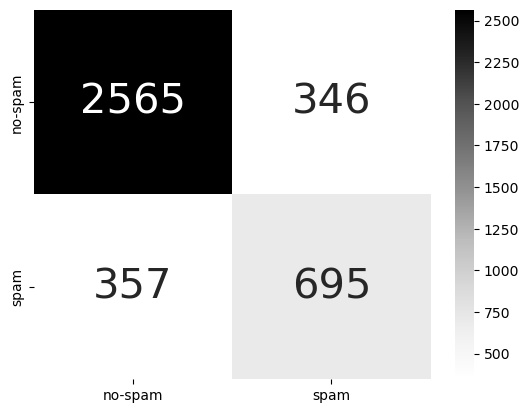

In [17]:
plotting_confusion_matrix(test_cm, task=1)


## Task 2

In [18]:
import torch
from torch import nn

seed_everything(42)
model = TextCNN(task=2, kernel_sizes=[2, 3, 5], num_filters=32, drop=0.5, spatial_dropout=False, mode='static').to(device)
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-3)
criterion = nn.CrossEntropyLoss(weight=spam_class_weights.to(device), reduction='mean')
early_stopping = EarlyStopping(patience=10, delta=0)
history = train(model, criterion, optimizer, train_dataloader, val_dataloader, epochs=40, model_name="TextCNN", early_stopping=early_stopping, task=2)


Loaded pretrained embeddings, weights are not trainable.
Epoch 1/40
----------------------------------------------------------------------


  0%|          | 0/56 [00:00<?, ?it/s]

Train Accuracy: 0.4908 - Valid F1-score: 0.3450 - Train Loss: 1.2232
Valid Accuracy: 0.5922 - Valid F1-score: 0.4255 - Valid Loss: 1.1797
Validation loss decreased (inf --> 1.179680). Saving model ...
Epoch 2/40
----------------------------------------------------------------------


  0%|          | 0/56 [00:00<?, ?it/s]

Train Accuracy: 0.6081 - Valid F1-score: 0.4652 - Train Loss: 0.9529
Valid Accuracy: 0.6772 - Valid F1-score: 0.4814 - Valid Loss: 1.0320
Validation loss decreased (1.179680 --> 1.032036). Saving model ...
Epoch 3/40
----------------------------------------------------------------------


  0%|          | 0/56 [00:00<?, ?it/s]

Train Accuracy: 0.6750 - Valid F1-score: 0.5335 - Train Loss: 0.7684
Valid Accuracy: 0.6790 - Valid F1-score: 0.5007 - Valid Loss: 0.9640
Validation loss decreased (1.032036 --> 0.963999). Saving model ...
Epoch 4/40
----------------------------------------------------------------------


  0%|          | 0/56 [00:00<?, ?it/s]

Train Accuracy: 0.7143 - Valid F1-score: 0.5768 - Train Loss: 0.6314
Valid Accuracy: 0.7030 - Valid F1-score: 0.5221 - Valid Loss: 0.9301
Validation loss decreased (0.963999 --> 0.930132). Saving model ...
Epoch 5/40
----------------------------------------------------------------------


  0%|          | 0/56 [00:00<?, ?it/s]

Train Accuracy: 0.7580 - Valid F1-score: 0.6278 - Train Loss: 0.5236
Valid Accuracy: 0.7520 - Valid F1-score: 0.5483 - Valid Loss: 0.9420
EarlyStopping counter: 1 out of 10
Epoch 6/40
----------------------------------------------------------------------


  0%|          | 0/56 [00:00<?, ?it/s]

Train Accuracy: 0.8021 - Valid F1-score: 0.6818 - Train Loss: 0.4113
Valid Accuracy: 0.7646 - Valid F1-score: 0.5639 - Valid Loss: 1.0060
EarlyStopping counter: 2 out of 10
Epoch 7/40
----------------------------------------------------------------------


  0%|          | 0/56 [00:00<?, ?it/s]

Train Accuracy: 0.8261 - Valid F1-score: 0.7117 - Train Loss: 0.3406
Valid Accuracy: 0.7653 - Valid F1-score: 0.5582 - Valid Loss: 1.0323
EarlyStopping counter: 3 out of 10
Epoch 8/40
----------------------------------------------------------------------


  0%|          | 0/56 [00:00<?, ?it/s]

Train Accuracy: 0.8582 - Valid F1-score: 0.7457 - Train Loss: 0.2892
Valid Accuracy: 0.7709 - Valid F1-score: 0.5427 - Valid Loss: 1.1051
EarlyStopping counter: 4 out of 10
Epoch 9/40
----------------------------------------------------------------------


  0%|          | 0/56 [00:00<?, ?it/s]

Train Accuracy: 0.8721 - Valid F1-score: 0.7694 - Train Loss: 0.2488
Valid Accuracy: 0.7716 - Valid F1-score: 0.5384 - Valid Loss: 1.1754
EarlyStopping counter: 5 out of 10
Epoch 10/40
----------------------------------------------------------------------


  0%|          | 0/56 [00:00<?, ?it/s]

Train Accuracy: 0.8839 - Valid F1-score: 0.7813 - Train Loss: 0.2171
Valid Accuracy: 0.7684 - Valid F1-score: 0.5385 - Valid Loss: 1.2934
EarlyStopping counter: 6 out of 10
Epoch 11/40
----------------------------------------------------------------------


  0%|          | 0/56 [00:00<?, ?it/s]

Train Accuracy: 0.8964 - Valid F1-score: 0.8058 - Train Loss: 0.1950
Valid Accuracy: 0.7854 - Valid F1-score: 0.5433 - Valid Loss: 1.3962
EarlyStopping counter: 7 out of 10
Epoch 12/40
----------------------------------------------------------------------


  0%|          | 0/56 [00:00<?, ?it/s]

Train Accuracy: 0.9094 - Valid F1-score: 0.8206 - Train Loss: 0.1773
Valid Accuracy: 0.7848 - Valid F1-score: 0.5373 - Valid Loss: 1.4947
EarlyStopping counter: 8 out of 10
Epoch 13/40
----------------------------------------------------------------------


  0%|          | 0/56 [00:00<?, ?it/s]

Train Accuracy: 0.9103 - Valid F1-score: 0.8183 - Train Loss: 0.1634
Valid Accuracy: 0.7867 - Valid F1-score: 0.5532 - Valid Loss: 1.5969
EarlyStopping counter: 9 out of 10
Epoch 14/40
----------------------------------------------------------------------


  0%|          | 0/56 [00:00<?, ?it/s]

Train Accuracy: 0.9196 - Valid F1-score: 0.8380 - Train Loss: 0.1515
Valid Accuracy: 0.7911 - Valid F1-score: 0.5522 - Valid Loss: 1.6120
EarlyStopping counter: 10 out of 10
Early stopping.


In [19]:
save_visualization_history(history, 'TextCNN', task=2)
plotting_history(history)


In [20]:
import os
import torch

model_name = "TextCNN"
model_path = os.path.join(model_name, f"{model_name}_last_model_(2).pth")
model = TextCNN(task=2).to(device)
model.load_state_dict(torch.load(model_path))
true_labels, predicts = test(model, test_dataloader, task=2)
test_cm = evaluate(true_labels, predicts)


Loaded pretrained embeddings, weights are not trainable.


  0%|          | 0/16 [00:00<?, ?it/s]

Accuracy: 0.7858
Precision: 0.5841
Recall: 0.6585
F1-score: 0.6064
Confusion matrix:
 [[2458   46  278  129]
 [  17   29    4    4]
 [ 100    1  192   16]
 [ 203   11   40  435]]
              precision    recall  f1-score   support

           0     0.8848    0.8444    0.8641      2911
           1     0.3333    0.5370    0.4113        54
           2     0.3735    0.6214    0.4666       309
           3     0.7449    0.6313    0.6834       689

    accuracy                         0.7858      3963
   macro avg     0.5841    0.6585    0.6064      3963
weighted avg     0.8131    0.7858    0.7955      3963



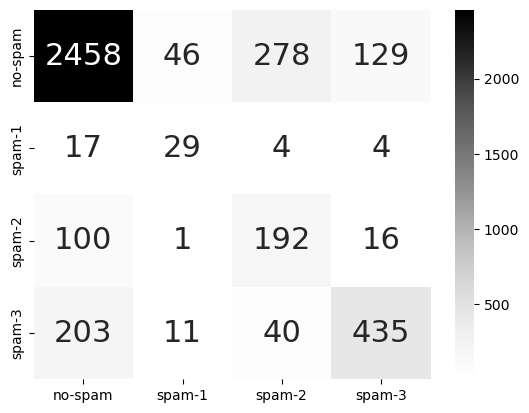

In [21]:
plotting_confusion_matrix(test_cm, task=2)


# BiLSTM

## Task 1

In [22]:
import torch
from torch import nn

seed_everything(42)
model = BiLSTM(task=1, hidden_size=64, drop=0.5, spatial_dropout=True, mode='static').to(device)
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-3)
criterion = nn.CrossEntropyLoss(weight=class_weights.to(device), reduction='mean')
early_stopping = EarlyStopping(patience=10, delta=0)
history = train(model, criterion, optimizer, train_dataloader, val_dataloader, epochs=40, model_name="BiLSTM", early_stopping=early_stopping, task=1)


Loaded pretrained embeddings, weights are not trainable.
Epoch 1/40
----------------------------------------------------------------------


  0%|          | 0/56 [00:00<?, ?it/s]

Train Accuracy: 0.6752 - Valid F1-score: 0.6310 - Train Loss: 0.6274
Valid Accuracy: 0.7797 - Valid F1-score: 0.7372 - Valid Loss: 0.5002
Validation loss decreased (inf --> 0.500192). Saving model ...
Epoch 2/40
----------------------------------------------------------------------


  0%|          | 0/56 [00:00<?, ?it/s]

Train Accuracy: 0.7903 - Valid F1-score: 0.7533 - Train Loss: 0.4694
Valid Accuracy: 0.8326 - Valid F1-score: 0.7778 - Valid Loss: 0.4694
Validation loss decreased (0.500192 --> 0.469443). Saving model ...
Epoch 3/40
----------------------------------------------------------------------


  0%|          | 0/56 [00:00<?, ?it/s]

Train Accuracy: 0.8365 - Valid F1-score: 0.8036 - Train Loss: 0.3946
Valid Accuracy: 0.8269 - Valid F1-score: 0.7783 - Valid Loss: 0.4510
Validation loss decreased (0.469443 --> 0.450980). Saving model ...
Epoch 4/40
----------------------------------------------------------------------


  0%|          | 0/56 [00:00<?, ?it/s]

Train Accuracy: 0.8599 - Valid F1-score: 0.8309 - Train Loss: 0.3357
Valid Accuracy: 0.8389 - Valid F1-score: 0.7865 - Valid Loss: 0.4799
EarlyStopping counter: 1 out of 10
Epoch 5/40
----------------------------------------------------------------------


  0%|          | 0/56 [00:00<?, ?it/s]

Train Accuracy: 0.8851 - Valid F1-score: 0.8596 - Train Loss: 0.2870
Valid Accuracy: 0.8320 - Valid F1-score: 0.7793 - Valid Loss: 0.4881
EarlyStopping counter: 2 out of 10
Epoch 6/40
----------------------------------------------------------------------


  0%|          | 0/56 [00:00<?, ?it/s]

Train Accuracy: 0.9079 - Valid F1-score: 0.8866 - Train Loss: 0.2372
Valid Accuracy: 0.8408 - Valid F1-score: 0.7830 - Valid Loss: 0.5532
EarlyStopping counter: 3 out of 10
Epoch 7/40
----------------------------------------------------------------------


  0%|          | 0/56 [00:00<?, ?it/s]

Train Accuracy: 0.9243 - Valid F1-score: 0.9058 - Train Loss: 0.2031
Valid Accuracy: 0.8295 - Valid F1-score: 0.7771 - Valid Loss: 0.5470
EarlyStopping counter: 4 out of 10
Epoch 8/40
----------------------------------------------------------------------


  0%|          | 0/56 [00:00<?, ?it/s]

Train Accuracy: 0.9282 - Valid F1-score: 0.9107 - Train Loss: 0.1846
Valid Accuracy: 0.8263 - Valid F1-score: 0.7739 - Valid Loss: 0.5724
EarlyStopping counter: 5 out of 10
Epoch 9/40
----------------------------------------------------------------------


  0%|          | 0/56 [00:00<?, ?it/s]

Train Accuracy: 0.9404 - Valid F1-score: 0.9256 - Train Loss: 0.1581
Valid Accuracy: 0.8351 - Valid F1-score: 0.7739 - Valid Loss: 0.7221
EarlyStopping counter: 6 out of 10
Epoch 10/40
----------------------------------------------------------------------


  0%|          | 0/56 [00:00<?, ?it/s]

Train Accuracy: 0.9453 - Valid F1-score: 0.9315 - Train Loss: 0.1493
Valid Accuracy: 0.8332 - Valid F1-score: 0.7698 - Valid Loss: 0.7710
EarlyStopping counter: 7 out of 10
Epoch 11/40
----------------------------------------------------------------------


  0%|          | 0/56 [00:00<?, ?it/s]

Train Accuracy: 0.9502 - Valid F1-score: 0.9375 - Train Loss: 0.1324
Valid Accuracy: 0.8345 - Valid F1-score: 0.7768 - Valid Loss: 0.7577
EarlyStopping counter: 8 out of 10
Epoch 12/40
----------------------------------------------------------------------


  0%|          | 0/56 [00:00<?, ?it/s]

Train Accuracy: 0.9546 - Valid F1-score: 0.9430 - Train Loss: 0.1192
Valid Accuracy: 0.8313 - Valid F1-score: 0.7715 - Valid Loss: 0.7657
EarlyStopping counter: 9 out of 10
Epoch 13/40
----------------------------------------------------------------------


  0%|          | 0/56 [00:00<?, ?it/s]

Train Accuracy: 0.9572 - Valid F1-score: 0.9462 - Train Loss: 0.1141
Valid Accuracy: 0.8332 - Valid F1-score: 0.7664 - Valid Loss: 0.9433
EarlyStopping counter: 10 out of 10
Early stopping.


In [23]:
save_visualization_history(history, 'BiLSTM', task=1)
plotting_history(history)


In [24]:
import os
import torch

model_name = "BiLSTM"
model_path = os.path.join(model_name, f"{model_name}_last_model_(1).pth")
model = BiLSTM(task=1).to(device)
model.load_state_dict(torch.load(model_path))
true_labels, predicts = test(model, test_dataloader, task=1)
test_cm = evaluate(true_labels, predicts)


Loaded pretrained embeddings, weights are not trainable.


  0%|          | 0/16 [00:00<?, ?it/s]

Accuracy: 0.8294
Precision: 0.7907
Recall: 0.7494
F1-score: 0.7655
Confusion matrix:
 [[2678  233]
 [ 443  609]]
              precision    recall  f1-score   support

           0     0.8581    0.9200    0.8879      2911
           1     0.7233    0.5789    0.6431      1052

    accuracy                         0.8294      3963
   macro avg     0.7907    0.7494    0.7655      3963
weighted avg     0.8223    0.8294    0.8229      3963



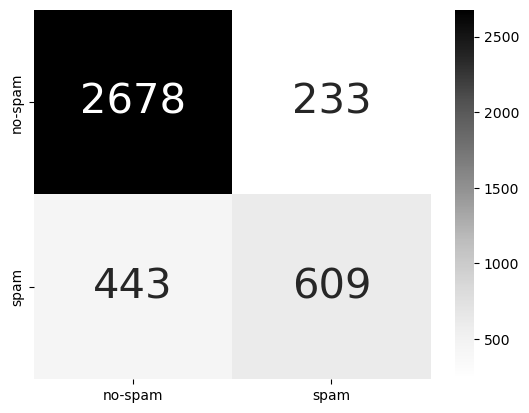

In [25]:
plotting_confusion_matrix(test_cm, task=1)


## Task 2

In [26]:
import torch
from torch import nn

seed_everything(42)
model = BiLSTM(task=2, hidden_size=64, drop=0.5, spatial_dropout=True, mode='static').to(device)
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-3)
criterion = nn.CrossEntropyLoss(weight=spam_class_weights.to(device), reduction='mean')
early_stopping = EarlyStopping(patience=10, delta=0)
history = train(model, criterion, optimizer, train_dataloader, val_dataloader, epochs=40, model_name="BiLSTM", early_stopping=early_stopping, task=2)


Loaded pretrained embeddings, weights are not trainable.
Epoch 1/40
----------------------------------------------------------------------


  0%|          | 0/56 [00:00<?, ?it/s]

Train Accuracy: 0.6560 - Valid F1-score: 0.3111 - Train Loss: 1.3476
Valid Accuracy: 0.6797 - Valid F1-score: 0.4117 - Valid Loss: 1.2745
Validation loss decreased (inf --> 1.274476). Saving model ...
Epoch 2/40
----------------------------------------------------------------------


  0%|          | 0/56 [00:00<?, ?it/s]

Train Accuracy: 0.5253 - Valid F1-score: 0.3919 - Train Loss: 1.0223
Valid Accuracy: 0.5104 - Valid F1-score: 0.4211 - Valid Loss: 1.0635
Validation loss decreased (1.274476 --> 1.063518). Saving model ...
Epoch 3/40
----------------------------------------------------------------------


  0%|          | 0/56 [00:00<?, ?it/s]

Train Accuracy: 0.5950 - Valid F1-score: 0.4788 - Train Loss: 0.8416
Valid Accuracy: 0.6249 - Valid F1-score: 0.4885 - Valid Loss: 0.9222
Validation loss decreased (1.063518 --> 0.922243). Saving model ...
Epoch 4/40
----------------------------------------------------------------------


  0%|          | 0/56 [00:00<?, ?it/s]

Train Accuracy: 0.6775 - Valid F1-score: 0.5609 - Train Loss: 0.6790
Valid Accuracy: 0.6772 - Valid F1-score: 0.5133 - Valid Loss: 0.9023
Validation loss decreased (0.922243 --> 0.902319). Saving model ...
Epoch 5/40
----------------------------------------------------------------------


  0%|          | 0/56 [00:00<?, ?it/s]

Train Accuracy: 0.7234 - Valid F1-score: 0.6000 - Train Loss: 0.5859
Valid Accuracy: 0.7187 - Valid F1-score: 0.5376 - Valid Loss: 0.9009
Validation loss decreased (0.902319 --> 0.900895). Saving model ...
Epoch 6/40
----------------------------------------------------------------------


  0%|          | 0/56 [00:00<?, ?it/s]

Train Accuracy: 0.7635 - Valid F1-score: 0.6479 - Train Loss: 0.5126
Valid Accuracy: 0.7369 - Valid F1-score: 0.5441 - Valid Loss: 0.9464
EarlyStopping counter: 1 out of 10
Epoch 7/40
----------------------------------------------------------------------


  0%|          | 0/56 [00:00<?, ?it/s]

Train Accuracy: 0.7807 - Valid F1-score: 0.6576 - Train Loss: 0.4529
Valid Accuracy: 0.7118 - Valid F1-score: 0.5343 - Valid Loss: 0.9785
EarlyStopping counter: 2 out of 10
Epoch 8/40
----------------------------------------------------------------------


  0%|          | 0/56 [00:00<?, ?it/s]

Train Accuracy: 0.8081 - Valid F1-score: 0.6877 - Train Loss: 0.4021
Valid Accuracy: 0.7332 - Valid F1-score: 0.5297 - Valid Loss: 0.9887
EarlyStopping counter: 3 out of 10
Epoch 9/40
----------------------------------------------------------------------


  0%|          | 0/56 [00:00<?, ?it/s]

Train Accuracy: 0.8348 - Valid F1-score: 0.7297 - Train Loss: 0.3392
Valid Accuracy: 0.7577 - Valid F1-score: 0.5572 - Valid Loss: 1.0386
EarlyStopping counter: 4 out of 10
Epoch 10/40
----------------------------------------------------------------------


  0%|          | 0/56 [00:00<?, ?it/s]

Train Accuracy: 0.8587 - Valid F1-score: 0.7615 - Train Loss: 0.2974
Valid Accuracy: 0.7621 - Valid F1-score: 0.5720 - Valid Loss: 1.1309
EarlyStopping counter: 5 out of 10
Epoch 11/40
----------------------------------------------------------------------


  0%|          | 0/56 [00:00<?, ?it/s]

Train Accuracy: 0.8713 - Valid F1-score: 0.7789 - Train Loss: 0.2735
Valid Accuracy: 0.7747 - Valid F1-score: 0.5645 - Valid Loss: 1.2637
EarlyStopping counter: 6 out of 10
Epoch 12/40
----------------------------------------------------------------------


  0%|          | 0/56 [00:00<?, ?it/s]

Train Accuracy: 0.8834 - Valid F1-score: 0.7947 - Train Loss: 0.2387
Valid Accuracy: 0.7583 - Valid F1-score: 0.5676 - Valid Loss: 1.2978
EarlyStopping counter: 7 out of 10
Epoch 13/40
----------------------------------------------------------------------


  0%|          | 0/56 [00:00<?, ?it/s]

Train Accuracy: 0.8909 - Valid F1-score: 0.8077 - Train Loss: 0.2324
Valid Accuracy: 0.7678 - Valid F1-score: 0.5494 - Valid Loss: 1.6032
EarlyStopping counter: 8 out of 10
Epoch 14/40
----------------------------------------------------------------------


  0%|          | 0/56 [00:00<?, ?it/s]

Train Accuracy: 0.8941 - Valid F1-score: 0.8078 - Train Loss: 0.2158
Valid Accuracy: 0.7684 - Valid F1-score: 0.5432 - Valid Loss: 1.3288
EarlyStopping counter: 9 out of 10
Epoch 15/40
----------------------------------------------------------------------


  0%|          | 0/56 [00:00<?, ?it/s]

Train Accuracy: 0.8970 - Valid F1-score: 0.8110 - Train Loss: 0.2011
Valid Accuracy: 0.7860 - Valid F1-score: 0.5680 - Valid Loss: 1.6665
EarlyStopping counter: 10 out of 10
Early stopping.


In [27]:
save_visualization_history(history, 'BiLSTM', task=2)
plotting_history(history)


In [28]:
import os
import torch

model_name = "BiLSTM"
model_path = os.path.join(model_name, f"{model_name}_last_model_(2).pth")
model = BiLSTM(task=2).to(device)
model.load_state_dict(torch.load(model_path))
true_labels, predicts = test(model, test_dataloader, task=2)
test_cm = evaluate(true_labels, predicts)


Loaded pretrained embeddings, weights are not trainable.


  0%|          | 0/16 [00:00<?, ?it/s]

Accuracy: 0.7837
Precision: 0.6007
Recall: 0.6600
F1-score: 0.6104
Confusion matrix:
 [[2459   35  322   95]
 [  18   28    6    2]
 [  88    2  212    7]
 [ 222   12   48  407]]
              precision    recall  f1-score   support

           0     0.8823    0.8447    0.8631      2911
           1     0.3636    0.5185    0.4275        54
           2     0.3605    0.6861    0.4727       309
           3     0.7965    0.5907    0.6783       689

    accuracy                         0.7837      3963
   macro avg     0.6007    0.6600    0.6104      3963
weighted avg     0.8196    0.7837    0.7946      3963



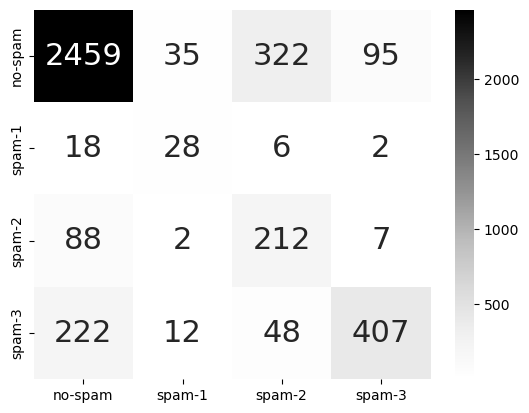

In [29]:
plotting_confusion_matrix(test_cm, task=2)


# BiGRU

## Task 1

In [30]:
import torch
from torch import nn

seed_everything(42)
model = BiGRU(task=1, hidden_size=64, drop=0.5, spatial_dropout=True, mode='static').to(device)
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-3)
criterion = nn.CrossEntropyLoss(weight=class_weights.to(device), reduction='mean')
early_stopping = EarlyStopping(patience=10, delta=0)
history = train(model, criterion, optimizer, train_dataloader, val_dataloader, epochs=40, model_name="BiGRU", early_stopping=early_stopping, task=1)


Loaded pretrained embeddings, weights are not trainable.
Epoch 1/40
----------------------------------------------------------------------


  0%|          | 0/56 [00:00<?, ?it/s]

Train Accuracy: 0.7308 - Valid F1-score: 0.6546 - Train Loss: 0.6235
Valid Accuracy: 0.7508 - Valid F1-score: 0.7192 - Valid Loss: 0.4865
Validation loss decreased (inf --> 0.486458). Saving model ...
Epoch 2/40
----------------------------------------------------------------------


  0%|          | 0/56 [00:00<?, ?it/s]

Train Accuracy: 0.7956 - Valid F1-score: 0.7593 - Train Loss: 0.4574
Valid Accuracy: 0.8357 - Valid F1-score: 0.7777 - Valid Loss: 0.4628
Validation loss decreased (0.486458 --> 0.462788). Saving model ...
Epoch 3/40
----------------------------------------------------------------------


  0%|          | 0/56 [00:00<?, ?it/s]

Train Accuracy: 0.8400 - Valid F1-score: 0.8075 - Train Loss: 0.3878
Valid Accuracy: 0.8238 - Valid F1-score: 0.7784 - Valid Loss: 0.4323
Validation loss decreased (0.462788 --> 0.432301). Saving model ...
Epoch 4/40
----------------------------------------------------------------------


  0%|          | 0/56 [00:00<?, ?it/s]

Train Accuracy: 0.8632 - Valid F1-score: 0.8341 - Train Loss: 0.3296
Valid Accuracy: 0.8433 - Valid F1-score: 0.7918 - Valid Loss: 0.4567
EarlyStopping counter: 1 out of 10
Epoch 5/40
----------------------------------------------------------------------


  0%|          | 0/56 [00:00<?, ?it/s]

Train Accuracy: 0.8934 - Valid F1-score: 0.8696 - Train Loss: 0.2698
Valid Accuracy: 0.8521 - Valid F1-score: 0.7981 - Valid Loss: 0.4893
EarlyStopping counter: 2 out of 10
Epoch 6/40
----------------------------------------------------------------------


  0%|          | 0/56 [00:00<?, ?it/s]

Train Accuracy: 0.9106 - Valid F1-score: 0.8895 - Train Loss: 0.2346
Valid Accuracy: 0.8005 - Valid F1-score: 0.7616 - Valid Loss: 0.4782
EarlyStopping counter: 3 out of 10
Epoch 7/40
----------------------------------------------------------------------


  0%|          | 0/56 [00:00<?, ?it/s]

Train Accuracy: 0.9211 - Valid F1-score: 0.9020 - Train Loss: 0.2028
Valid Accuracy: 0.8357 - Valid F1-score: 0.7877 - Valid Loss: 0.5213
EarlyStopping counter: 4 out of 10
Epoch 8/40
----------------------------------------------------------------------


  0%|          | 0/56 [00:00<?, ?it/s]

Train Accuracy: 0.9335 - Valid F1-score: 0.9173 - Train Loss: 0.1701
Valid Accuracy: 0.8288 - Valid F1-score: 0.7799 - Valid Loss: 0.5268
EarlyStopping counter: 5 out of 10
Epoch 9/40
----------------------------------------------------------------------


  0%|          | 0/56 [00:00<?, ?it/s]

Train Accuracy: 0.9413 - Valid F1-score: 0.9267 - Train Loss: 0.1549
Valid Accuracy: 0.8345 - Valid F1-score: 0.7827 - Valid Loss: 0.5873
EarlyStopping counter: 6 out of 10
Epoch 10/40
----------------------------------------------------------------------


  0%|          | 0/56 [00:00<?, ?it/s]

Train Accuracy: 0.9467 - Valid F1-score: 0.9333 - Train Loss: 0.1438
Valid Accuracy: 0.8282 - Valid F1-score: 0.7789 - Valid Loss: 0.5576
EarlyStopping counter: 7 out of 10
Epoch 11/40
----------------------------------------------------------------------


  0%|          | 0/56 [00:00<?, ?it/s]

Train Accuracy: 0.9508 - Valid F1-score: 0.9385 - Train Loss: 0.1248
Valid Accuracy: 0.8307 - Valid F1-score: 0.7717 - Valid Loss: 0.7177
EarlyStopping counter: 8 out of 10
Epoch 12/40
----------------------------------------------------------------------


  0%|          | 0/56 [00:00<?, ?it/s]

Train Accuracy: 0.9539 - Valid F1-score: 0.9422 - Train Loss: 0.1201
Valid Accuracy: 0.8351 - Valid F1-score: 0.7778 - Valid Loss: 0.7302
EarlyStopping counter: 9 out of 10
Epoch 13/40
----------------------------------------------------------------------


  0%|          | 0/56 [00:00<?, ?it/s]

Train Accuracy: 0.9581 - Valid F1-score: 0.9475 - Train Loss: 0.1025
Valid Accuracy: 0.8326 - Valid F1-score: 0.7728 - Valid Loss: 0.8190
EarlyStopping counter: 10 out of 10
Early stopping.


In [31]:
save_visualization_history(history, 'BiGRU', task=1)
plotting_history(history)


In [32]:
import os
import torch

model_name = "BiGRU"
model_path = os.path.join(model_name, f"{model_name}_last_model_(1).pth")
model = BiGRU(task=1).to(device)
model.load_state_dict(torch.load(model_path))
true_labels, predicts = test(model, test_dataloader, task=1)
test_cm = evaluate(true_labels, predicts)


Loaded pretrained embeddings, weights are not trainable.


  0%|          | 0/16 [00:00<?, ?it/s]

Accuracy: 0.8312
Precision: 0.7856
Recall: 0.7725
F1-score: 0.7786
Confusion matrix:
 [[2613  298]
 [ 371  681]]
              precision    recall  f1-score   support

           0     0.8757    0.8976    0.8865      2911
           1     0.6956    0.6473    0.6706      1052

    accuracy                         0.8312      3963
   macro avg     0.7856    0.7725    0.7786      3963
weighted avg     0.8279    0.8312    0.8292      3963



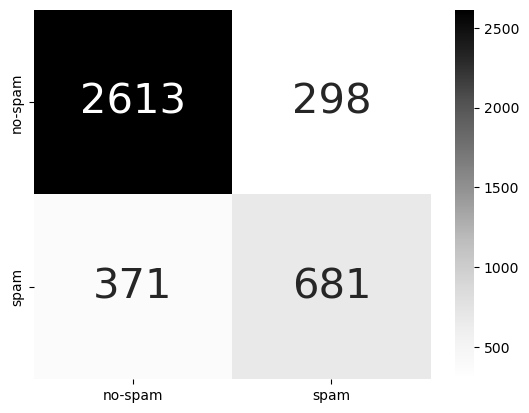

In [33]:
plotting_confusion_matrix(test_cm, task=1)


## Task 2

In [34]:
import torch
from torch import nn

seed_everything(42)
model = BiGRU(task=2, hidden_size=64, drop=0.5, spatial_dropout=True, mode='static').to(device)
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-3)
criterion = nn.CrossEntropyLoss(weight=spam_class_weights.to(device), reduction='mean')
early_stopping = EarlyStopping(patience=10, delta=0)
history = train(model, criterion, optimizer, train_dataloader, val_dataloader, epochs=40, model_name="BiGRU", early_stopping=early_stopping, task=2)


Loaded pretrained embeddings, weights are not trainable.
Epoch 1/40
----------------------------------------------------------------------


  0%|          | 0/56 [00:00<?, ?it/s]

Train Accuracy: 0.4756 - Valid F1-score: 0.3062 - Train Loss: 1.3301
Valid Accuracy: 0.4569 - Valid F1-score: 0.3303 - Valid Loss: 1.2476
Validation loss decreased (inf --> 1.247598). Saving model ...
Epoch 2/40
----------------------------------------------------------------------


  0%|          | 0/56 [00:00<?, ?it/s]

Train Accuracy: 0.4461 - Valid F1-score: 0.3574 - Train Loss: 1.0282
Valid Accuracy: 0.5469 - Valid F1-score: 0.4198 - Valid Loss: 1.1488
Validation loss decreased (1.247598 --> 1.148766). Saving model ...
Epoch 3/40
----------------------------------------------------------------------


  0%|          | 0/56 [00:00<?, ?it/s]

Train Accuracy: 0.5882 - Valid F1-score: 0.4674 - Train Loss: 0.8113
Valid Accuracy: 0.6136 - Valid F1-score: 0.4671 - Valid Loss: 0.9661
Validation loss decreased (1.148766 --> 0.966131). Saving model ...
Epoch 4/40
----------------------------------------------------------------------


  0%|          | 0/56 [00:00<?, ?it/s]

Train Accuracy: 0.6754 - Valid F1-score: 0.5405 - Train Loss: 0.6736
Valid Accuracy: 0.6665 - Valid F1-score: 0.4959 - Valid Loss: 0.9650
Validation loss decreased (0.966131 --> 0.965024). Saving model ...
Epoch 5/40
----------------------------------------------------------------------


  0%|          | 0/56 [00:00<?, ?it/s]

Train Accuracy: 0.7194 - Valid F1-score: 0.5881 - Train Loss: 0.5698
Valid Accuracy: 0.7401 - Valid F1-score: 0.5478 - Valid Loss: 1.0779
EarlyStopping counter: 1 out of 10
Epoch 6/40
----------------------------------------------------------------------


  0%|          | 0/56 [00:00<?, ?it/s]

Train Accuracy: 0.7602 - Valid F1-score: 0.6368 - Train Loss: 0.4676
Valid Accuracy: 0.7520 - Valid F1-score: 0.5574 - Valid Loss: 1.1061
EarlyStopping counter: 2 out of 10
Epoch 7/40
----------------------------------------------------------------------


  0%|          | 0/56 [00:00<?, ?it/s]

Train Accuracy: 0.8013 - Valid F1-score: 0.6824 - Train Loss: 0.4042
Valid Accuracy: 0.7508 - Valid F1-score: 0.5720 - Valid Loss: 1.1415
EarlyStopping counter: 3 out of 10
Epoch 8/40
----------------------------------------------------------------------


  0%|          | 0/56 [00:00<?, ?it/s]

Train Accuracy: 0.8214 - Valid F1-score: 0.7093 - Train Loss: 0.3584
Valid Accuracy: 0.7590 - Valid F1-score: 0.5565 - Valid Loss: 1.2590
EarlyStopping counter: 4 out of 10
Epoch 9/40
----------------------------------------------------------------------


  0%|          | 0/56 [00:00<?, ?it/s]

Train Accuracy: 0.8399 - Valid F1-score: 0.7282 - Train Loss: 0.3047
Valid Accuracy: 0.7407 - Valid F1-score: 0.5515 - Valid Loss: 1.4199
EarlyStopping counter: 5 out of 10
Epoch 10/40
----------------------------------------------------------------------


  0%|          | 0/56 [00:00<?, ?it/s]

Train Accuracy: 0.8645 - Valid F1-score: 0.7758 - Train Loss: 0.2723
Valid Accuracy: 0.7621 - Valid F1-score: 0.5560 - Valid Loss: 1.4604
EarlyStopping counter: 6 out of 10
Epoch 11/40
----------------------------------------------------------------------


  0%|          | 0/56 [00:00<?, ?it/s]

Train Accuracy: 0.8758 - Valid F1-score: 0.7732 - Train Loss: 0.2485
Valid Accuracy: 0.7923 - Valid F1-score: 0.5728 - Valid Loss: 1.6580
EarlyStopping counter: 7 out of 10
Epoch 12/40
----------------------------------------------------------------------


  0%|          | 0/56 [00:00<?, ?it/s]

Train Accuracy: 0.8796 - Valid F1-score: 0.7787 - Train Loss: 0.2415
Valid Accuracy: 0.7659 - Valid F1-score: 0.5630 - Valid Loss: 1.4798
EarlyStopping counter: 8 out of 10
Epoch 13/40
----------------------------------------------------------------------


  0%|          | 0/56 [00:00<?, ?it/s]

Train Accuracy: 0.8908 - Valid F1-score: 0.7975 - Train Loss: 0.2158
Valid Accuracy: 0.7627 - Valid F1-score: 0.5543 - Valid Loss: 1.7791
EarlyStopping counter: 9 out of 10
Epoch 14/40
----------------------------------------------------------------------


  0%|          | 0/56 [00:00<?, ?it/s]

Train Accuracy: 0.8954 - Valid F1-score: 0.8140 - Train Loss: 0.1934
Valid Accuracy: 0.7703 - Valid F1-score: 0.5512 - Valid Loss: 1.8998
EarlyStopping counter: 10 out of 10
Early stopping.


In [35]:
save_visualization_history(history, 'BiGRU', task=2)
plotting_history(history)


In [36]:
import os
import torch

model_name = "BiGRU"
model_path = os.path.join(model_name, f"{model_name}_last_model_(2).pth")
model = BiGRU(task=2).to(device)
model.load_state_dict(torch.load(model_path))
true_labels, predicts = test(model, test_dataloader, task=2)
test_cm = evaluate(true_labels, predicts)


Loaded pretrained embeddings, weights are not trainable.


  0%|          | 0/16 [00:00<?, ?it/s]

Accuracy: 0.7744
Precision: 0.5704
Recall: 0.6909
F1-score: 0.6095
Confusion matrix:
 [[2311   45  355  200]
 [  15   29    5    5]
 [  73    2  210   24]
 [ 128   14   28  519]]
              precision    recall  f1-score   support

           0     0.9145    0.7939    0.8499      2911
           1     0.3222    0.5370    0.4028        54
           2     0.3512    0.6796    0.4631       309
           3     0.6939    0.7533    0.7223       689

    accuracy                         0.7744      3963
   macro avg     0.5704    0.6909    0.6095      3963
weighted avg     0.8242    0.7744    0.7915      3963



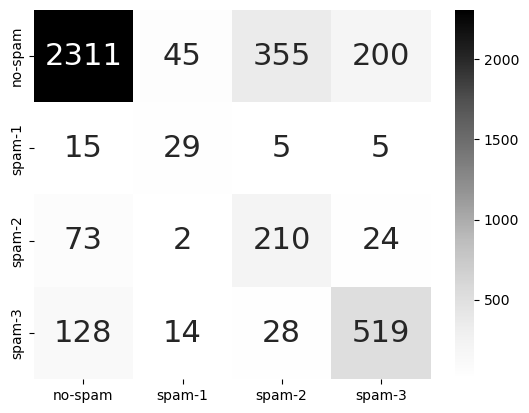

In [37]:
plotting_confusion_matrix(test_cm, task=2)
